(complementary:amr)=
# Error estimation & adaptive refinement

In this tutorial, we apply a Zienkiewicz-Zhu type error estimator and run an adaptive loop with these steps:
$$
\text{SOLVE}\rightarrow
\text{ESIMATE}\rightarrow
\text{MARK}\rightarrow
\text{REFINE}\rightarrow
\text{SOLVE} \rightarrow \ldots
$$

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np

### Geometry

The following geometry represents a heated chip embedded in another material that conducts away the heat.

In [2]:
def MakeGeometryOCC():
    square = Circle( (0,0), 2).Face() # create a rectangle with boundary conditions
    square.edges.name = "outer"
    square.faces.name = "air"

    el1 = MoveTo(-0.4, 0.2).Rectangle( 0.8, 0.1).Face() # create a rectangle with boundary conditions
    el1.edges.name = "el1"
    el1.vertices.name = "el1"

    el2 = MoveTo(-0.4, -0.2).Rectangle( 0.8, 0.1).Face() # create a rectangle with boundary conditions
    el2.edges.name = "el2"
    el2.vertices.name = "el2"

    dielec = MoveTo(-0.9, -0.1).Rectangle( 1.8, 0.3).Face()
    dielec.faces.name = "dielec"

    air = square  # subtract the rectangles from the air rectangle
    shape = Glue([air - dielec, dielec])
    shape =shape - el1 - el2

    ### adding extra specifications on the shape
    #predefined mesh size for the shape


    return OCCGeometry(shape, dim=2)

mesh = Mesh(MakeGeometryOCC().GenerateMesh(maxh=0.5))
mesh.Curve(3)
Draw(mesh);

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

### Spaces & forms

The problem is to find $u$ in $H_{0,D}^1$ satisfying 

$$
\int_\Omega \varepsilon \nabla u \cdot \nabla v = \int_\Omega f v 
$$

for all $v$ in $H_{0,D}^1$. We expect the solution to have singularities due to the nonconvex re-enrant angles and discontinuities in $\lambda$.

**On the notes adaptivity is explained using $\lambda$ instead of $\varepsilon$.**

In [3]:
fes = H1(mesh, order=3, dirichlet="el.*")
u, v = fes.TnT()

# one heat conductivity coefficient per sub-domain
eps = CoefficientFunction([1, 2])
a = BilinearForm(eps*grad(u)*grad(v)*dx)

# heat-source in inner subdomain
f = LinearForm(fes)

c = Preconditioner(a, type="multigrid", inverse="sparsecholesky")

electrode = mesh.BoundaryCF({"el1":1, "el2":-1}, default = 0 ) # define the boundary conditions
gfu = GridFunction(fes)
gfu.Set(electrode, definedon=mesh.Boundaries("el.*")) # set the boundary conditions


Note that the linear system is not yet assembled above.

### Solve 

Since we must solve multiple times, we define a function to solve the boundary value problem, where assembly, update, and solve occurs.

In [4]:
def SolveBVP(gfu):
    fes.Update()
    gfu.Update()
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data +=inv* (f.vec - a.mat * gfu.vec) # solve the system


In [5]:
SolveBVP(gfu)
Draw(gfu);

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

### Estimate

We implement a gradient-recovery-type error estimator. For this, we need an H(div) space for flux recovery. We must compute the flux  of the computed solution and interpolate it into this H(div) space.

In [6]:
space_flux = HDiv(mesh, order=2)
#space_flux = VectorH1(mesh, order=2)

gf_flux = GridFunction(space_flux, "flux")

flux = eps * grad(gfu)
gf_flux.Set(flux)

**Element-wise error estimator:** On each element $T$, set 

$$
\eta_T^2 = \int_T \frac{1}{\varepsilon} 
|\varepsilon \nabla u_h - I_h(\varepsilon \nabla u_h) |^2
$$

where $u_h$ is the computed solution `gfu` and $I_h$ is the interpolation performed by `Set` in NGSolve.


In [7]:
err = 1/eps*(flux-gf_flux)*(flux-gf_flux)
Draw(err, mesh, 'error_representation')

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [8]:
eta2 = Integrate(err, mesh, VOL, element_wise=True)

# print only the first 10 values
print(np.array(eta2)[:10], "...")

[4.21844043e-08 3.51993719e-08 1.15855690e-07 9.16675703e-07
 8.56872830e-08 4.69599758e-07 1.35455783e-07 1.08785490e-06
 3.81167047e-08 2.91869337e-07] ...


The above values, one per element, lead us to identify elements which might have large error.


### Mark 

We mark elements with large error estimator for refinement.

In [9]:
maxerr = max(eta2)
print ("maxerr = ", maxerr)

for el in mesh.Elements():
    mesh.SetRefinementFlag(el, eta2[el.nr] > 0.25*maxerr)


maxerr =  0.17618069929529773


### Refine & solve again 

Refine marked elements:

In [10]:
mesh.Refine()
SolveBVP(gfu)
Draw(gfu);

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

### Automate the above steps

In [11]:
l = []    # l = list of estimated total error

def CalcError():

    # compute the flux:
    space_flux.Update()      
    gf_flux.Update()
    flux = eps * grad(gfu)        
    gf_flux.Set(flux) 
    
    # compute estimator:
    err = 1/eps*(flux-gf_flux)*(flux-gf_flux)
    eta2 = Integrate(err, mesh, VOL, element_wise=True)
    maxerr = max(eta2)
    l.append ((fes.ndof, sqrt(sum(eta2))))
    print("ndof =", fes.ndof, " maxerr =", maxerr)
    
    # mark for refinement (vectorized alternative)
    mesh.ngmesh.Elements2D().NumPy()["refine"] = eta2.NumPy() > 0.25*maxerr
    

In [12]:
CalcError()
mesh.Refine()
mesh.Curve(4);

ndof = 1652  maxerr = 0.09112442615012609


### Run the adaptive loop

In [13]:
level = 0 
while fes.ndof < 100000:  
    SolveBVP(gfu)
    level = level + 1
    if level%5 == 0:
        print('adaptive step #', level)
        Draw(gfu)
    CalcError()
    mesh.Refine()
    mesh.Curve(4)

SolveBVP(gfu)



ndof = 2261  maxerr = 0.04002281759106825
ndof = 3026  maxerr = 0.016862385222809195
ndof = 3884  maxerr = 0.0071647024304403156
ndof = 4763  maxerr = 0.003059766213456847
adaptive step # 5


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

ndof = 5519  maxerr = 0.0013107177246670083
ndof = 6428  maxerr = 0.0005624494617473979
ndof = 7277  maxerr = 0.00024166036698837937
ndof = 8507  maxerr = 0.00010387514475995984
ndof = 9851  maxerr = 4.4691827729711645e-05
adaptive step # 10


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

ndof = 11477  maxerr = 1.922457425108042e-05
ndof = 12926  maxerr = 8.273945682000414e-06
ndof = 14885  maxerr = 3.559813507988442e-06
ndof = 17162  maxerr = 1.532254564185486e-06
ndof = 20009  maxerr = 9.539192068213516e-07
adaptive step # 15


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

ndof = 21641  maxerr = 3.886656310807754e-07
ndof = 26072  maxerr = 1.6732390194083217e-07
ndof = 31460  maxerr = 6.298646340148813e-08
ndof = 38234  maxerr = 2.5169141452619706e-08
ndof = 45122  maxerr = 1.050401306320977e-08
adaptive step # 20


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

ndof = 53699  maxerr = 4.390017092141048e-09
ndof = 64940  maxerr = 1.8902728269000752e-09
ndof = 78116  maxerr = 8.385329670843026e-10
ndof = 93812  maxerr = 4.857835350235864e-10


### Plot history of adaptive convergence

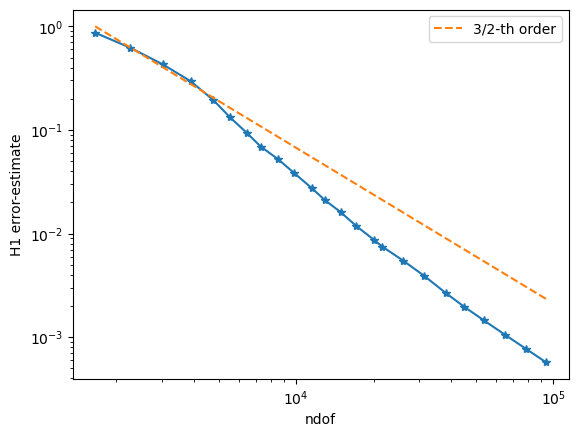

In [14]:
plt.yscale('log')
plt.xscale('log')
plt.xlabel("ndof")
plt.ylabel("H1 error-estimate")
ndof,err = zip(*l)
plt.plot(ndof,err, "-*")

plt.plot(ndof, [(ndof[0]/n)**(1.5)for n in ndof], "--", label="3/2-th order")

# plot the convergence rate line

plt.legend()
plt.ion()
plt.show()

In [15]:
N = 10
# fac = 0 if mesh.dim == 2 else 1
# p = [(-1+4*i/N,-2+4*j/N,fac * 2*k/N) for i in range(1,2*N) for j in range(1,2*N) for k in range(1,N)]
p = [(i / N, -1 + (2*j) / N, 0) for i in range(N+1) for j in range(N+1)]

fieldlines = flux._BuildFieldLines(
    mesh, p, num_fieldlines=N**3//5, randomized=False, length=0.3)
clipping = {"clipping": {"y": 0, "z": -1}}


Draw(-eps*grad(gfu), mesh, "X" , min = 0, max = 10);
Draw(-eps*grad(gfu), mesh,  "X", draw_vol=True, draw_surf=True, objects=[fieldlines],
     autoscale=True, min=0, max=10, settings={"Objects": {"Surface": False}}, **clipping);

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Surface': False…